In [1]:
# Standard imports
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import arviz
#import theano
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

import os, sys
#sys.stderr = open(os.devnull, "w")

# PyMC 4.0 imports
import pymc as pm
#import aesara.tensor as at 
#import aesara

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"]#.astype(theano.config.floatX)
county_idx, counties = pd.factorize(data.county)
coords = {"county": counties, "obs_id": np.arange(len(county_idx))}

In [3]:
data

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.871802
915,915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.526056
916,916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.629241
917,917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,27173.0,1.426590,84,1.335001


In [4]:
with pm.Model(coords=coords) as hierarchical_model:
    # Intercepts, non-centered
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
    sigma_a = pm.HalfNormal("sigma_a", 1.0)
    a = pm.Normal("a", dims="county") * sigma_a + mu_a
    
    # Slopes, non-centered
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=2.)
    sigma_b = pm.HalfNormal("sigma_b", 1.0)
    b = pm.Normal("b", dims="county") * sigma_b + mu_b
    
    eps = pm.HalfNormal("eps", 1.5)
    
    linear_predictor = a[county_idx] + b[county_idx] * data.floor.values
    
    y = pm.Normal(
        "y", mu=linear_predictor, sigma=eps, observed=data.log_radon, 
        dims="obs_id"
    )

In [5]:
with hierarchical_model:
    posterior_data = pm.sample(target_accept=0.9, draws=200, tune=200, chains=4, cores=4, progressbar=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a, mu_b, sigma_b, b, eps]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 2304 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
idata_pymc4.to_dict()['posterior']['mu_b'].ravel()

NameError: name 'idata_pymc4' is not defined

c:\Users\frand\miniconda3\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (87) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'b\nAITKIN'}>,
        <Axes: title={'center': 'b\nANOKA'}>],
       [<Axes: title={'center': 'b\nBECKER'}>,
        <Axes: title={'center': 'b\nBELTRAMI'}>,
        <Axes: title={'center': 'b\nBENTON'}>,
        <Axes: title={'center': 'b\nBIG STONE'}>],
       [<Axes: title={'center': 'b\nBLUE EARTH'}>,
        <Axes: title={'center': 'b\nBROWN'}>,
        <Axes: title={'center': 'b\nCARLTON'}>,
        <Axes: title={'center': 'b\nCARVER'}>],
       [<Axes: title={'center': 'b\nCASS'}>,
        <Axes: title={'center': 'b\nCHIPPEWA'}>,
        <Axes: title={'center': 'b\nCHISAGO'}>,
        <Axes: title={'center': 'b\nCLAY'}>],
       [<Axes: title={'center': 'b\nCLEARWATER'}>,
        <Axes: title={'center': 'b\nCOOK'}>,
        <Axes: title={'center': 'b\nCOTTONWOOD'}>,
        <Axes: title={'center': 'b\nCROW WING'}>],
       [<Axes: title={'center': 'b\nDAKOTA'}>,

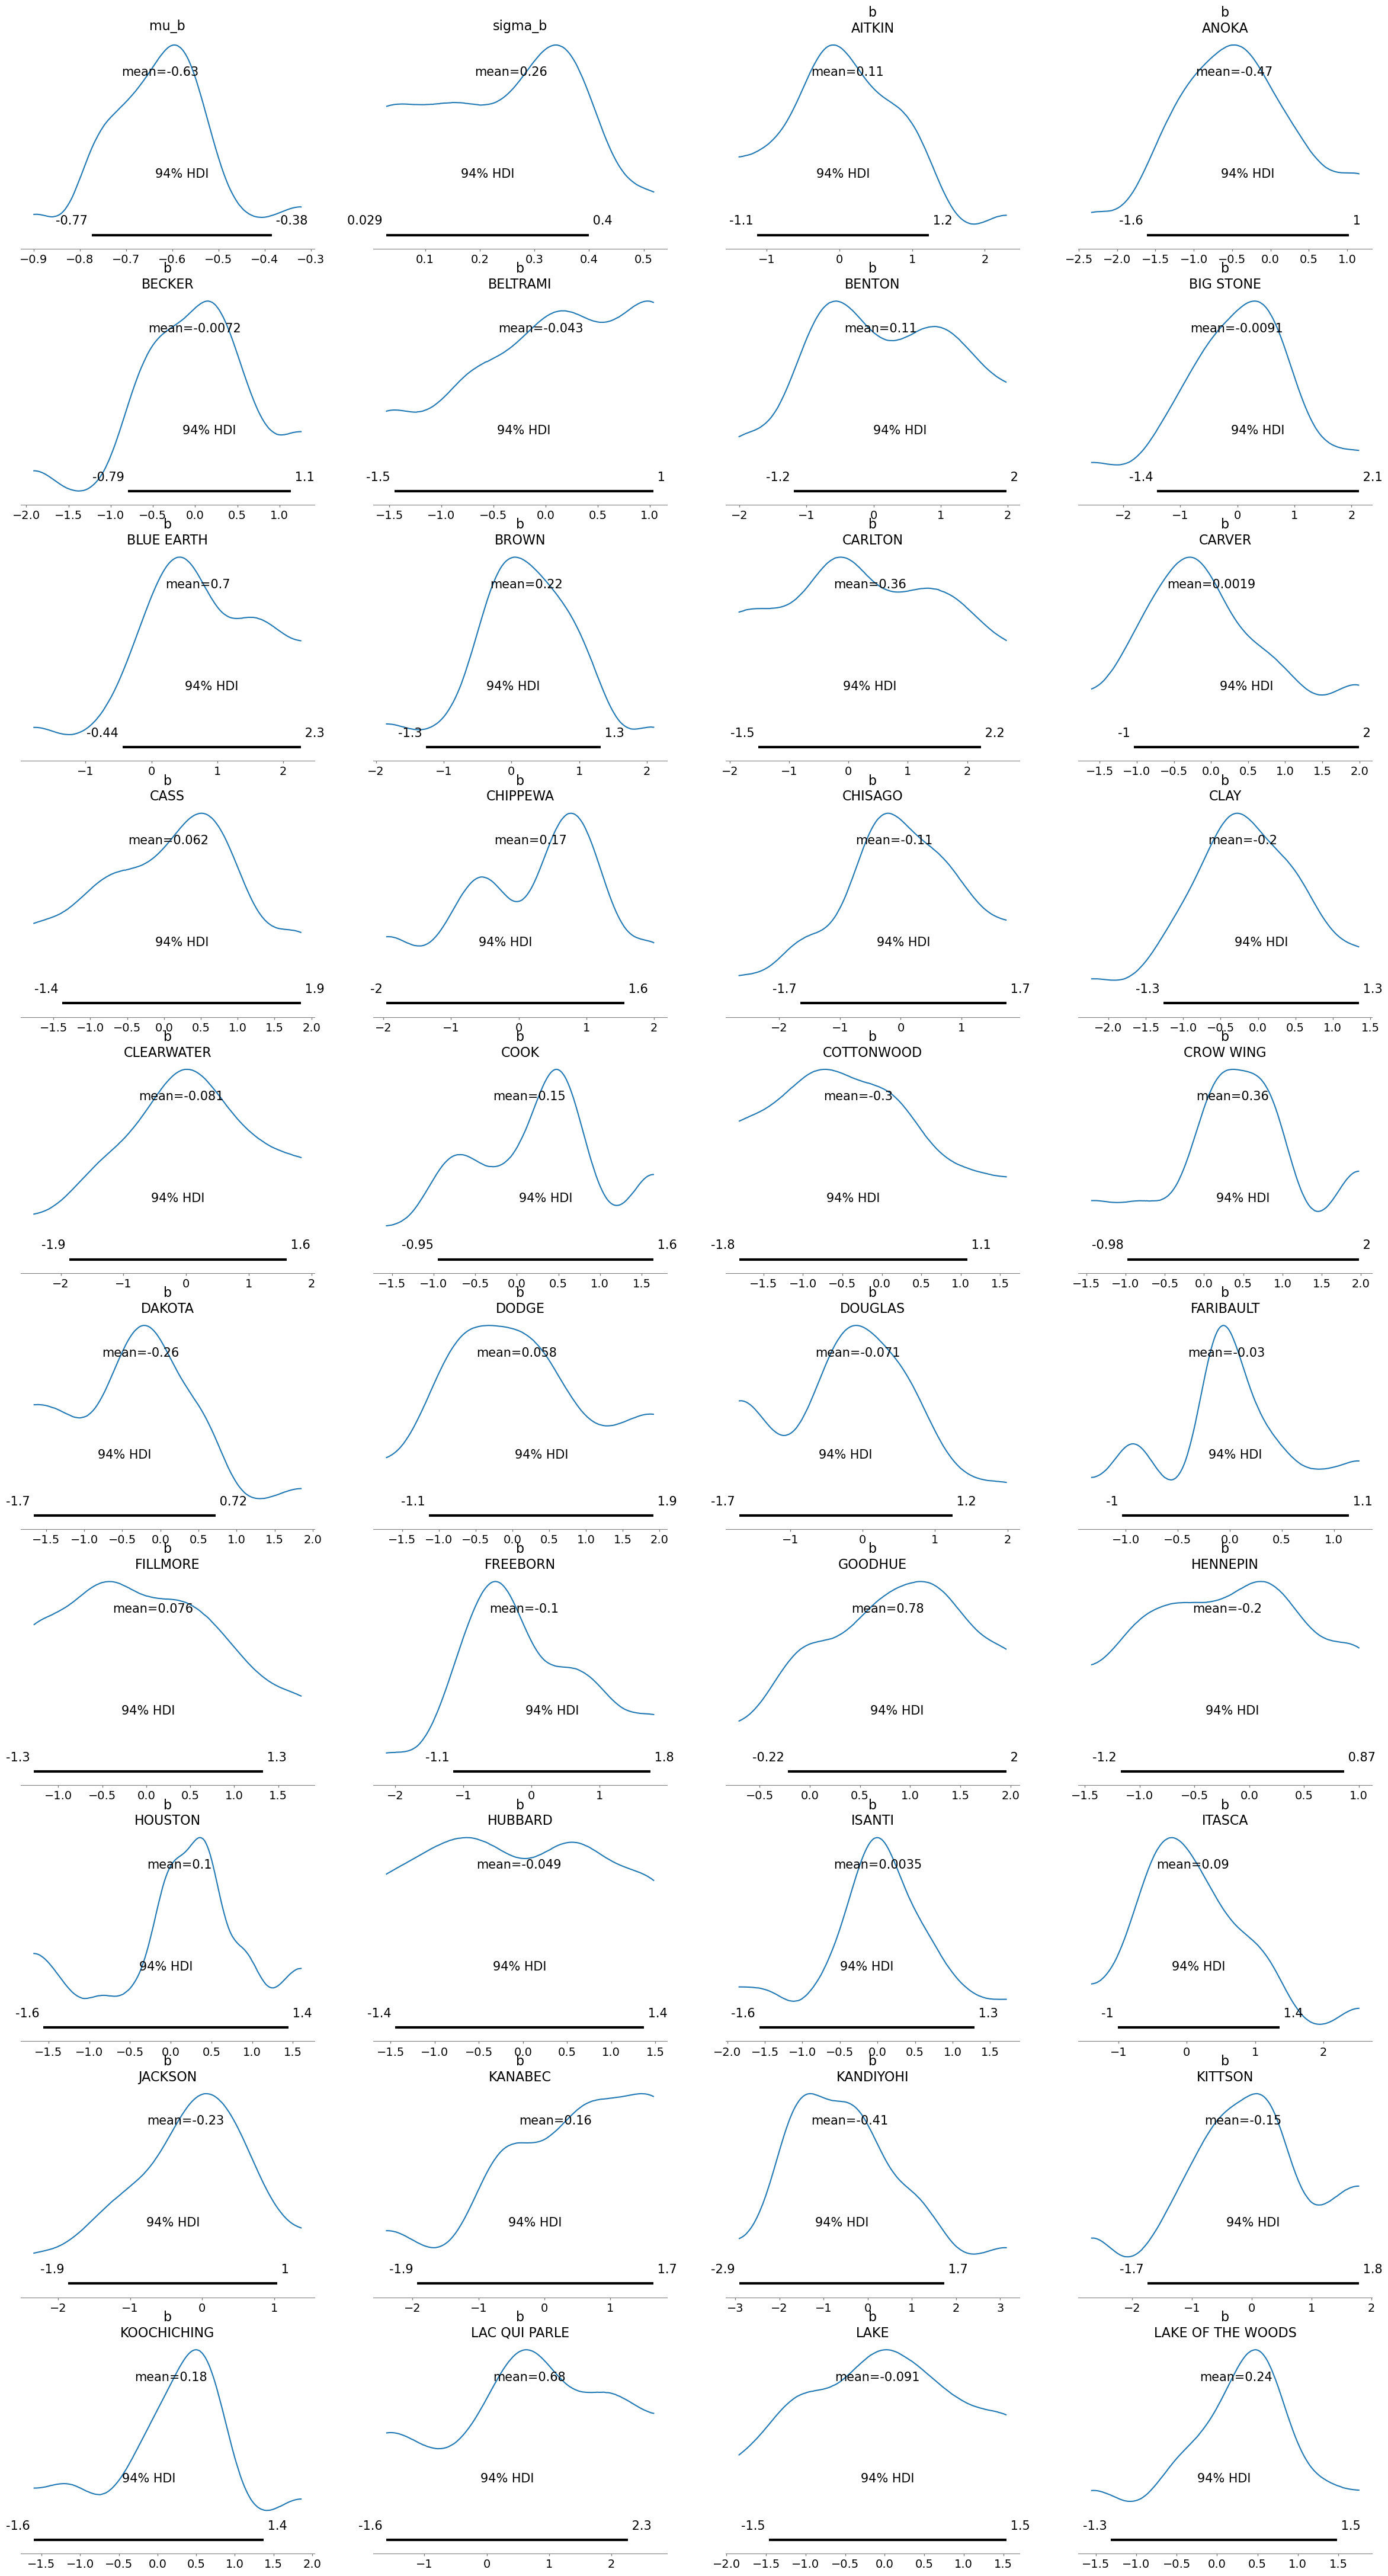

In [ ]:
arviz.plot_posterior(posterior_data, var_names=['mu_b', 'sigma_b', 'b'])

In [ ]:
with hierarchical_model:
    posterior_predictive_data = pm.sample_posterior_predictive(posterior_data)

Sampling: [y]


<Axes: xlabel='y / y'>

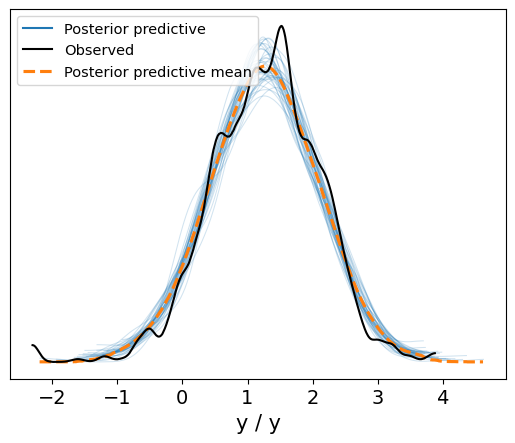

In [ ]:
arviz.plot_ppc(posterior_predictive_data)